In [1]:
# Install some necessary dependencies
!apt-get update > /dev/null
!apt-get install rustc > /dev/null
!apt-get install cargo > /dev/null
!pip install -q opengen > /dev/null

import opengen as og
import casadi.casadi as cs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# System parameters
nu, nx = 2, 3  # number of inputs and states
N = 40         # prediction horizon
L = 0.5        # wheel base
ts = 0.1       # sampling time
R = 5.0  # radius

# Path definition for ellipse
def reference_path(s):
    """
    Generate an elliptical reference path
    s: path parameter [0, 2π]
    """
    a = 6.0  # semi-major axis
    b = 4.0  # semi-minor axis

    # Parametric equations of ellipse
    x = a * cs.cos(s)
    y = b * cs.sin(s)

    # Calculate tangent angle (theta)
    # derivative of ellipse gives tangent direction
    dx_ds = -a * cs.sin(s)
    dy_ds = b * cs.cos(s)
    theta = cs.atan2(dy_ds, dx_ds)

    return x, y, theta

# Define optimization variables - combine u and s into one decision variable
u_all = cs.SX.sym('u', nu*N + 1)  # +1 for the path parameter
z0 = cs.SX.sym('z0', nx)      # initial state

# Extract control inputs and path parameter
u = u_all[:-1]    # all elements except the last one
s = u_all[-1]     # last element is the path parameter

# Extract initial states
x, y, theta = z0[0], z0[1], z0[2]

# Weights
q_path = 100    # path following weight
q_theta = 0.1   # heading weight
r = 1          # input weight
q_pathN = 200   # terminal path following weight
q_thetaN = 20   # terminal heading weight

# Cost function
cost = 0
s_var = s      # path parameter (will be optimized)

for t in range(0, nu*N, nu):
    # Get reference point on path
    xref, yref, thetaref = reference_path(s_var)

    # Path following error
    cost += q_path*((x-xref)**2 + (y-yref)**2) + q_theta*(theta-thetaref)**2

    # Control effort
    u_t = u[t:t+2]
    cost += r * cs.dot(u_t, u_t)

    # State propagation
    theta_dot = (1/L) * (u_t[1] * cs.cos(theta) - u_t[0] * cs.sin(theta))
    x += ts * (u_t[0] + L * cs.sin(theta) * theta_dot)
    y += ts * (u_t[1] - L * cs.cos(theta) * theta_dot)
    theta += ts * theta_dot

    # Update path parameter (using approximate arc length)
    a, b = 6.0, 3.0  # semi-major and semi-minor axes
    # Approximate instantaneous radius for ellipse
    r_approx = (a * b) / cs.sqrt((b * cs.cos(s_var))**2 + (a * cs.sin(s_var))**2)
    s_var += ts * cs.sqrt(u_t[0]**2 + u_t[1]**2) / r_approx

# Terminal cost
xref, yref, thetaref = reference_path(s_var)
cost += q_pathN*((x-xref)**2 + (y-yref)**2) + q_thetaN*(theta-thetaref)**2

# Constraints
umin = [-3.0] * (nu*N) + [0.0]      # min value for path parameter
umax = [3.0] * (nu*N) + [2*np.pi]   # max value for path parameter
bounds = og.constraints.Rectangle(umin, umax)


In [3]:
# Build optimizer
problem = og.builder.Problem(u_all, z0, cost).with_constraints(bounds)
build_config = og.config.BuildConfiguration() \
    .with_build_directory("path_following_optimizers") \
    .with_build_mode("debug") \
    .with_tcp_interface_config() \
    .with_build_python_bindings()

meta = og.config.OptimizerMeta() \
    .with_optimizer_name("path_following4")

solver_config = og.config.SolverConfiguration() \
    .with_tolerance(1e-5)

builder = og.builder.OpEnOptimizerBuilder(problem,
    meta,
    build_config,
    solver_config)
builder.build()

[INFO] --- Initialising builder: 'path_following4'
INFO:opengen.builder.OpEnOptimizerBuilder:--- Initialising builder: 'path_following4'
[INFO] Checking user parameters
INFO:opengen.builder.OpEnOptimizerBuilder:Checking user parameters
[INFO] Creating necessary folders
INFO:opengen.builder.OpEnOptimizerBuilder:Creating necessary folders
[INFO] Copying icasadi interface to target directory
INFO:opengen.builder.OpEnOptimizerBuilder:Copying icasadi interface to target directory
[INFO] Generating icasadi's Cargo.toml
INFO:opengen.builder.OpEnOptimizerBuilder:Generating icasadi's Cargo.toml
[INFO] Generating Cargo.toml for target optimizer
INFO:opengen.builder.OpEnOptimizerBuilder:Generating Cargo.toml for target optimizer
[INFO] Generating icasadi Rust library file
INFO:opengen.builder.OpEnOptimizerBuilder:Generating icasadi Rust library file
[INFO] Defining CasADi functions and generating C code
INFO:opengen.builder.OpEnOptimizerBuilder:Defining CasADi functions and generating C code
[INF

{'meta': {'name': 'path_following4',
  'version': '0.0.0',
  'author': ['John Smith'],
  'licence': 'MIT'},
 'problem': {'dim_decision_variables': 81,
  'dim_parameters': 3,
  'dim_constraints_penalty': 0,
  'dim_constraints_aug_lagrangian': 0},
 'build_config': {'target_system': None,
  'build_mode': 'debug',
  'rebuild': False,
  'build_directory': 'path_following_optimizers',
  'open_version': None,
  'build_c_bindings': False,
  'build_python_bindings': True,
  'tcp_interface_config': {'ip': '127.0.0.1', 'port': 8333}},
 'solver_config': {'tolerance': 1e-05,
  'initial_tolerance': 0.0001,
  'lbfgs_memory': 10,
  'max_inner_iterations': 500,
  'max_outer_iterations': 10,
  'constraints_tolerance': 0.0001,
  'initial_penalty': None,
  'penalty_weight_update_factor': 5.0,
  'max_duration_micros': 5000000,
  'inner_tolerance_update_factor': 0.1,
  'sufficient_decrease_coefficient': 0.1,
  'cbfgs_alpha': None,
  'cbfgs_epsilon': None,
  'cbfgs_sy_epsilon': None,
  'do_preconditioning': 

In [4]:
def mpc_controller(state):
    # Run MPC solver
    initial_guess = [1.0] * (nu*N + 1)  # +1 for path parameter
    result = solver.run(p=state,
                       initial_guess=initial_guess)
    return result.solution

In [5]:

# System dynamics
def system_dynamics(x, u):
    x_new = np.zeros(3)
    theta_dot = (1/L) * (u[1] * np.cos(x[2]) - u[0] * np.sin(x[2]))
    x_new[0] = x[0] + ts * (u[0] + L * np.sin(x[2]) * theta_dot)
    x_new[1] = x[1] + ts * (u[1] - L * np.cos(x[2]) * theta_dot)
    x_new[2] = x[2] + ts * theta_dot
    return x_new


In [6]:
import sys
sys.path.insert(1, 'path_following_optimizers/path_following4')
import path_following4
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Visualization code
def simulate_and_visualize(initial_state, num_steps):
    # Initialize storage for states and controls
    states = np.zeros((num_steps + 1, 3))
    controls = np.zeros((num_steps, 2))
    path_params = np.zeros(num_steps)
    states[0] = initial_state

    # Create solver instance
    solver = path_following4.solver()

    # Simulation loop
    for i in range(num_steps):
        # Get control input from MPC
        result = solver.run(p=states[i], initial_guess=[1.0] * (2*N + 1))
        u_star = result.solution

        # Store controls and path parameter
        controls[i] = u_star[0:2]
        path_params[i] = u_star[-1]

        # Update state
        states[i+1] = system_dynamics(states[i], controls[i])

    # Generate reference path points for plotting
    s_points = np.linspace(0, 2*np.pi, 100)
    ref_path_x = []
    ref_path_y = []
    for s in s_points:
        x, y, _ = reference_path(s)
        ref_path_x.append(float(x))
        ref_path_y.append(float(y))

    # Create figure with subplots
    plt.figure(figsize=(15, 10))

    # Plot 1: Path following visualization
    plt.subplot(2, 2, 1)
    plt.plot(ref_path_x, ref_path_y, 'b--', label='Reference Path')
    plt.plot(states[:, 0], states[:, 1], 'r.-', label='Robot Trajectory')
    plt.scatter(initial_state[0], initial_state[1], color='g', marker='o', label='Start')
    plt.scatter(states[-1, 0], states[-1, 1], color='r', marker='x', label='End')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Path Following Performance')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

    # Plot 2: Control inputs
    time = np.arange(0, num_steps * ts, ts)
    plt.subplot(2, 2, 2)
    plt.plot(time, controls[:, 0], 'b-', label='u1')
    plt.plot(time, controls[:, 1], 'r-', label='u2')
    plt.xlabel('Time [s]')
    plt.ylabel('Control Input')
    plt.title('Control Inputs vs Time')
    plt.grid(True)
    plt.legend()

    # Plot 3: Heading angle
    plt.subplot(2, 2, 3)
    plt.plot(time, states[:-1, 2], 'g-')
    plt.xlabel('Time [s]')
    plt.ylabel('Heading Angle [rad]')
    plt.title('Robot Heading vs Time')
    plt.grid(True)

    # Plot 4: Path parameter evolution
    plt.subplot(2, 2, 4)
    plt.plot(time, path_params, 'b-')
    plt.xlabel('Time [s]')
    plt.ylabel('Path Parameter s')
    plt.title('Path Parameter Evolution')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return states, ref_path_x, ref_path_y


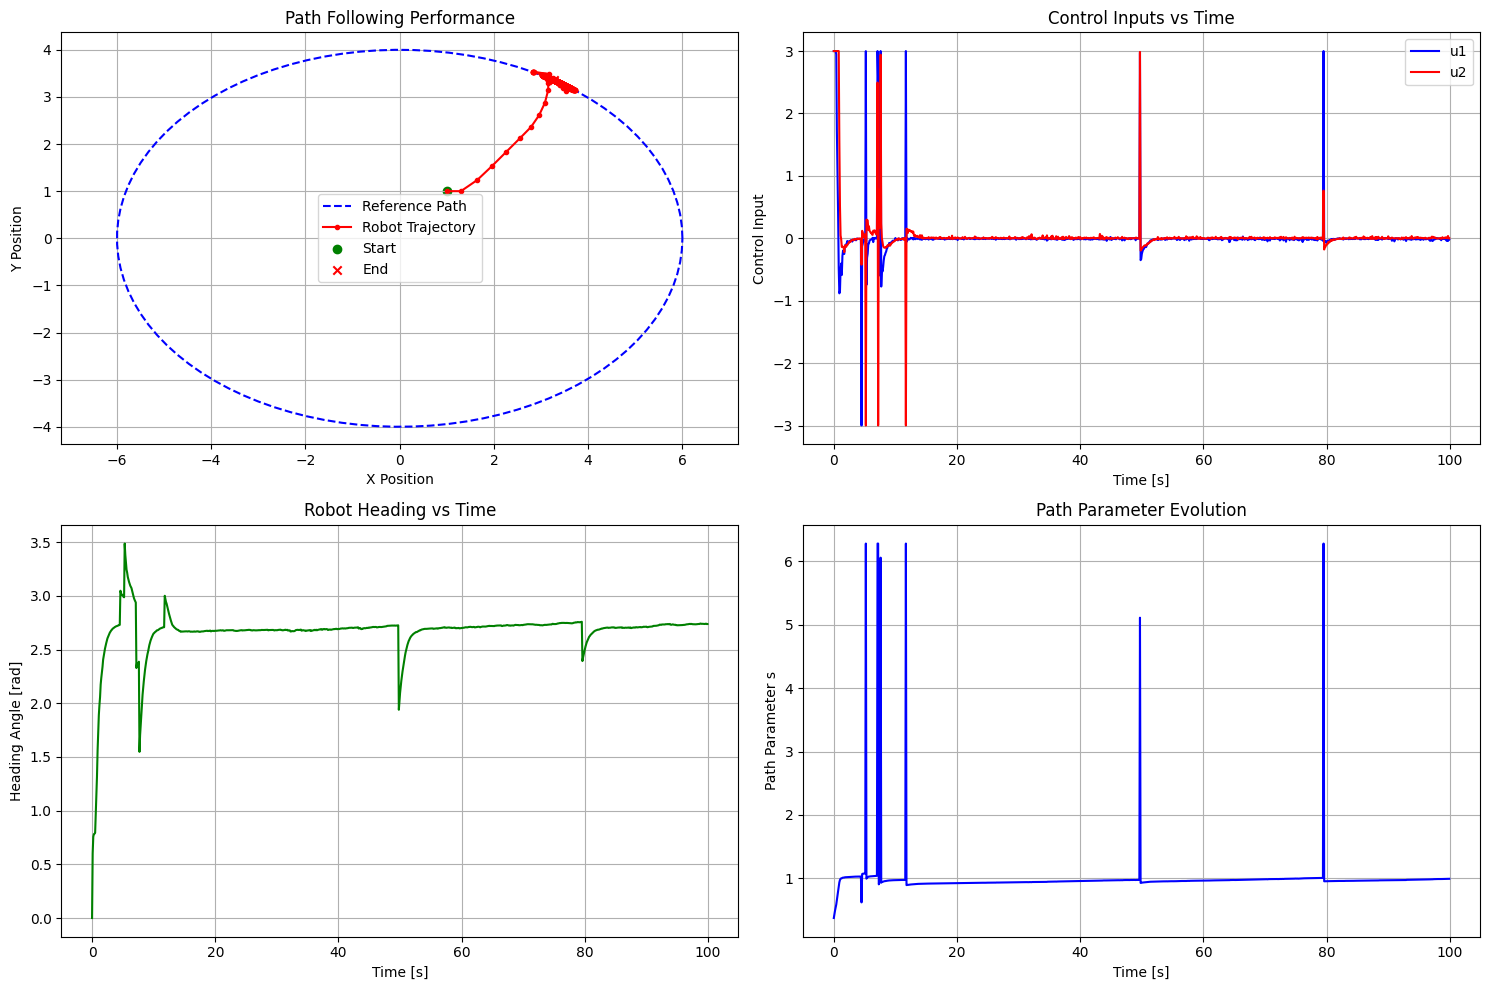

(array([[1.        , 1.        , 0.        ],
        [1.3       , 1.        , 0.6       ],
        [1.64415953, 1.2354522 , 0.75641588],
        ...,
        [3.27528588, 3.35469733, 2.7370481 ],
        [3.27420065, 3.35516198, 2.73757574],
        [3.27270905, 3.3557997 , 2.73904626]]),
 [6.0,
  5.987920058831307,
  5.951728876984772,
  5.8915721835762405,
  5.807692208378137,
  5.700426706445673,
  5.570207598096435,
  5.417559229719727,
  5.243096262418709,
  5.047521196987088,
  4.831621545186351,
  4.596266658713868,
  4.3424042286304205,
  4.071056469342793,
  3.783316002507135,
  3.4803414574271887,
  3.1633528056630142,
  2.833626448636096,
  2.4924900780113184,
  2.1413173295512316,
  1.7815222519696494,
  1.4145536130565637,
  1.0418890660015825,
  0.6650291994060666,
  0.2854914949424531,
  -0.09519578300884818,
  -0.47549974114073124,
  -0.8538890296397114,
  -1.2288400083911444,
  -1.59884288214021,
  -1.96240777990453,
  -2.318070754158772,
  -2.6643996756346446,
  -3.0

In [8]:
# Run simulation and visualization
initial_state = [1.0, 1.0, 0.0]  # [x, y, theta]
num_steps = 1000

simulate_and_visualize(initial_state, num_steps)


In [16]:
# Add animation of the robot movement
def animate_robot(states, ref_path_x, ref_path_y):
    plt.figure(figsize=(8, 8))
    for i in range(0, len(states), 2):  # Plot every second state to speed up animation
        plt.clf()
        # Plot reference path
        plt.plot(ref_path_x, ref_path_y, 'b--', label='Reference Path')

        # Plot robot trajectory until current point
        plt.plot(states[:i+1, 0], states[:i+1, 1], 'r.-', label='Robot Trajectory')

        # Plot current robot position
        robot_x = states[i, 0]
        robot_y = states[i, 1]
        robot_theta = states[i, 2]

        # Plot robot orientation (as an arrow)
        arrow_length = 0.3
        dx = arrow_length * np.cos(robot_theta)
        dy = arrow_length * np.sin(robot_theta)
        plt.arrow(robot_x, robot_y, dx, dy, head_width=0.1, head_length=0.1, fc='r', ec='r')

        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Robot Motion Animation (t = {i*ts:.1f}s)')
        plt.legend()

        plt.pause(0.1)
    plt.show()


In [19]:
# num_steps = 100
# # Generate reference path points
# s_points = np.linspace(0, 2*np.pi, 100)
# ref_path_x = []
# ref_path_y = []
# for s in s_points:
#     x, y, _ = reference_path(s)
#     ref_path_x.append(float(x))
#     ref_path_y.append(float(y))

# # Run simulation first to get states
# states = np.zeros((num_steps + 1, 3))
# states[0] = initial_state
# solver = path_following.solver()

# for i in range(num_steps):
#     result = solver.run(p=states[i], initial_guess=[1.0] * (2*N + 1))
#     u_star = result.solution
#     states[i+1] = system_dynamics(states[i], u_star[0:2])

# # Animate the results
# animate_robot(states, ref_path_x, ref_path_y)